In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [ ]:
daisy_path = '/content/drive/MyDrive/Dataset/Flowers dataset/daisy'
dandelion_path = '/content/drive/MyDrive/Dataset/Flowers dataset/dandelion'
rose_path = '/content/drive/MyDrive/Dataset/Flowers dataset/rose'
sunflower_path = '/content/drive/MyDrive/Dataset/Flowers dataset/sunflower'
tulip_path = '/content/drive/MyDrive/Dataset/Flowers dataset/tulip'

In [ ]:
count = 0
dirs = os.listdir('/content/drive/MyDrive/Dataset/Flowers dataset/')
for dir in dirs:
  files = list(os.listdir('/content/drive/MyDrive/Dataset/Flowers dataset/' + dir))
  print(dir + ' Folder has '+ str(len(files)) + ' Images')
  count = count + len(files)
print('Images Folder has '+ str(count) + ' Images')

tulip Folder has 984 Images
daisy Folder has 764 Images
rose Folder has 784 Images
sunflower Folder has 733 Images
dandelion Folder has 1052 Images
Images Folder has 4317 Images


In [ ]:
base_dir = '/content/drive/MyDrive/Dataset/Flowers dataset/'
img_size = 180
batch = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed = 123,
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       batch_size = batch,
                                                       image_size = (img_size, img_size)
                                                       )

val_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed = 123,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       batch_size = batch,
                                                       image_size = (img_size, img_size)
                                                       )

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [ ]:
flower_name = train_ds.class_names
flower_name

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

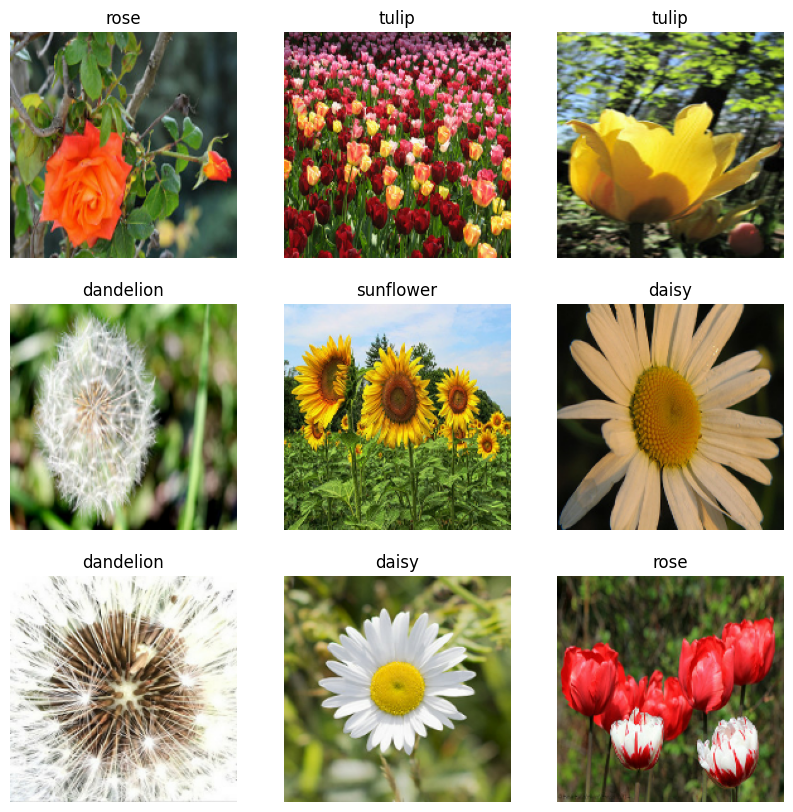

In [ ]:
i = 0
plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(flower_name[labels[i]])
    plt.axis('off')


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Data Augmentation

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

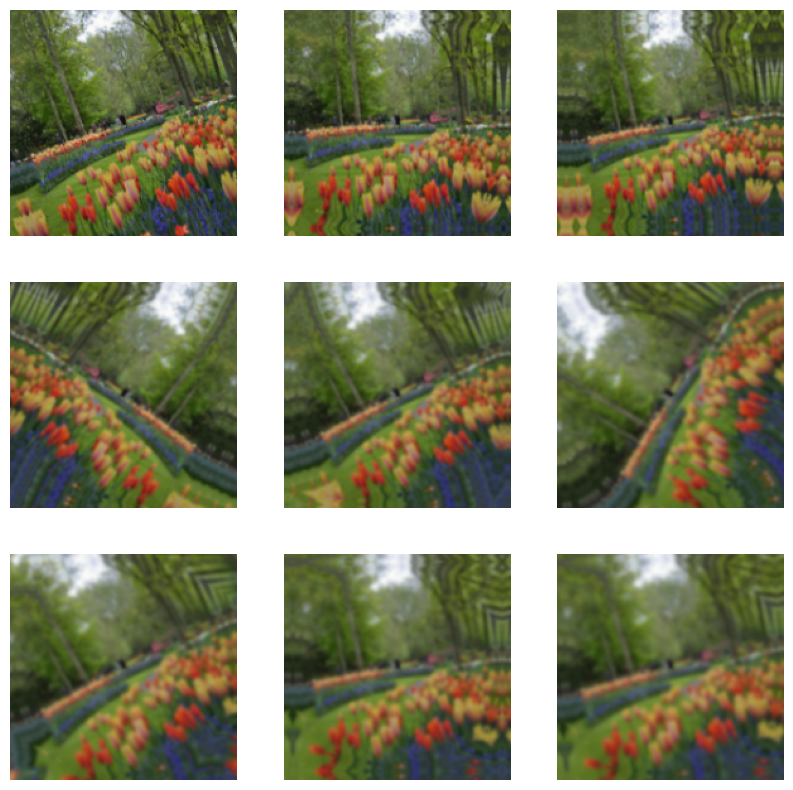

In [ ]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16,3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(32,3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(64,3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(5)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.3045 - loss: 1.6915 - val_accuracy: 0.5122 - val_loss: 1.1382
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5420 - loss: 1.1076 - val_accuracy: 0.5944 - val_loss: 1.0454
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6056 - loss: 1.0221 - val_accuracy: 0.6211 - val_loss: 0.9418
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6245 - loss: 0.9525 - val_accuracy: 0.6280 - val_loss: 0.9538
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6490 - loss: 0.8911 - val_accuracy: 0.6466 - val_loss: 0.8909
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6763 - loss: 0.8560 - val_accuracy: 0.6744 - val_loss: 0.8406
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6958 - loss: 0.7964 - val_accuracy: 0.6616 - val_loss: 0.8954
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7191 - loss: 0.7545 - val_accu

In [ ]:
flower_name = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

In [ ]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_name[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [ ]:
classify_images('/content/drive/MyDrive/Dataset/Flowers dataset/daisy/100080576_f52e8ee070_n.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


'The Image belongs to daisy with a score of 71.50421142578125'

In [ ]:
import pickle

In [ ]:
model.save('Flower_Recog_Model.keras')